## This notebook gives an overview about the cluster utilization during each submitted job.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [24]:
job_chars = pd.read_parquet('data/jobs_utilization.parquet')
job_chars

,Batch_class,Submission_date,Waited,CPU,Memory,End_date,Mem_utilization,CPU_utilization
index,,,,,,,,
8e2c3d09f0a6aecf,clmedium,2020-02-06 19:03:48,567.683333,19.950777,15.35,2020-02-07 04:31:28,10.580440,0.789678
3fe9afee11b2eb7a,cllong,2020-02-06 19:03:48,1921.216667,19.945657,14.10,2020-02-08 03:05:01,11.727911,0.776399
962f66f60dc03aab,clmedium,2020-02-06 19:25:09,174.966667,31.809137,2.04,2020-02-06 22:20:07,77.394293,0.440478
83eddbb936e98c67,clmedium,2020-02-06 19:46:31,1801.266667,18.998504,15.34,2020-02-08 01:47:47,10.560089,0.778152
a80766a2c509391e,cllong,2020-02-06 19:46:31,4344.483333,31.910880,2.00,2020-02-09 20:10:59,82.220649,0.506175
...,...,...,...,...,...,...,...,...
c57264b584ed22fd,clexpres,2020-10-07 13:09:50,35.150000,29.285537,7.79,2020-10-07 13:44:59,23.207638,0.437076
f24f80f34924bd61,clexpres,2020-10-07 13:19:51,0.266667,20.729966,7.49,2020-10-07 13:20:07,NaN,NaN
6d0554fc54b46e19,clexpres,2020-10-07 13:29:52,3.566667,21.332792,7.40,2020-10-07 13:33:26,NaN,NaN


In [3]:
host_logs = pd.read_parquet('data/host_logs.parquet')
job_raw = pd.read_parquet('data/job_chars.parquet')

In [25]:
interactivity = pd.read_parquet('data/interactivity.parquet')
interactivity

,interactivity score,normalized mean,normalized max
Identifier,,,
000030ecd19c9c04,0.151966,2.700000,0.900000
0000e2fb93bf367f,39.535012,117.285097,1.193402
00020fcd04947084,0.000000,0.000000,0.000000
0002286e1d7e428d,0.004353,0.004375,0.004365
0002441ec4986135,0.001644,1.256186,0.785502
...,...,...,...
fffb2d67011101c5,4.089659,22.448665,1.974427
fffd086716a4d46c,0.004373,0.004393,0.004382
ffff38341e8c6b3b,31.907856,1.648952,0.953827


Adding interactivity score to the dataset

In [26]:
job_chars = pd.merge(job_chars, interactivity, left_index=True, right_index=True)

Density function of the interactivity scores. Can the two peaks be interpreted as interactive/not-interactive jobs?

Text(0.5, 1.0, 'Normalized by CPU score')

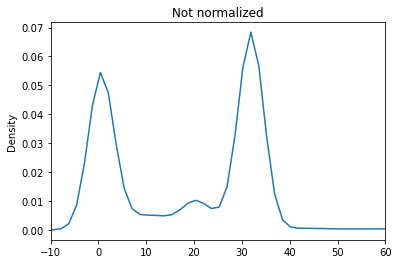

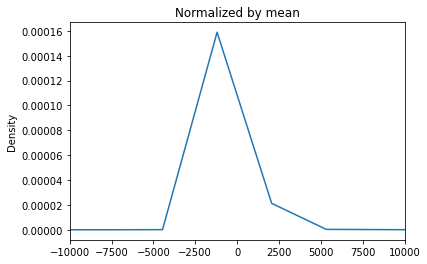

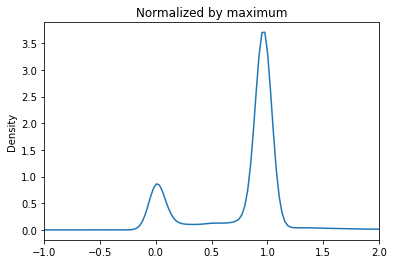

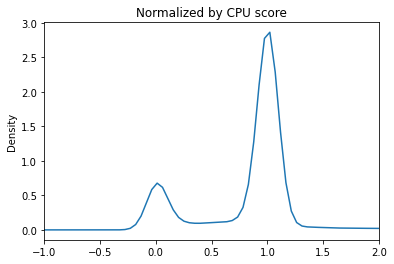

In [42]:
plt.figure()
job_chars['interactivity score'].plot.kde(xlim=(-10,60))
plt.title('Not normalized')
plt.figure()
job_chars['normalized mean'].plot.kde(xlim=(-10000,10000))
plt.title('Normalized by mean')
plt.figure()
job_chars['normalized max'].plot.kde(xlim=(-1,2))
plt.title('Normalized by maximum')
plt.figure()
(job_chars['interactivity score']/job_chars['CPU']).plot.kde(xlim=(-1,2))
plt.title('Normalized by CPU score')

In [4]:
batch_classes = ['clexpres', 'clmedium', 'cllong', 'clbigmem', 'clfo2','feque']

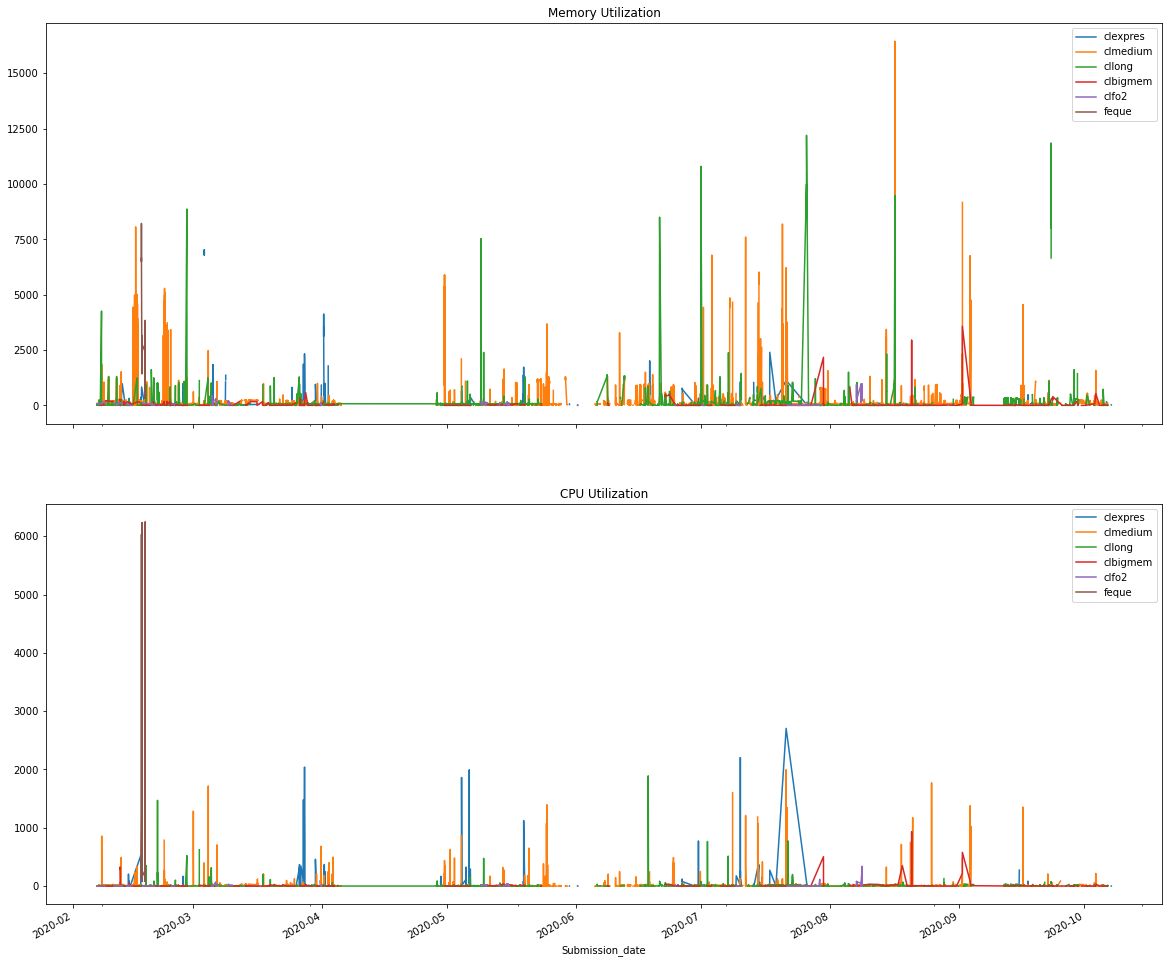

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(20,18),sharex=True)

for batch_class in batch_classes:
    job_bclass = job_chars[job_chars['Batch_class'].str.contains(batch_class)]
    #Memory Utilization:
    job_bclass.plot('Submission_date','Mem_utilization',ax=ax1, label=batch_class)
    #CPU utilization:
    job_bclass.plot('Submission_date','CPU_utilization',ax=ax2, label=batch_class)
    
ax1.set_title('Memory Utilization')
ax1.legend()
ax2.set_title('CPU Utilization')
ax2.legend()

In [6]:
job_chars.Waited /=60.

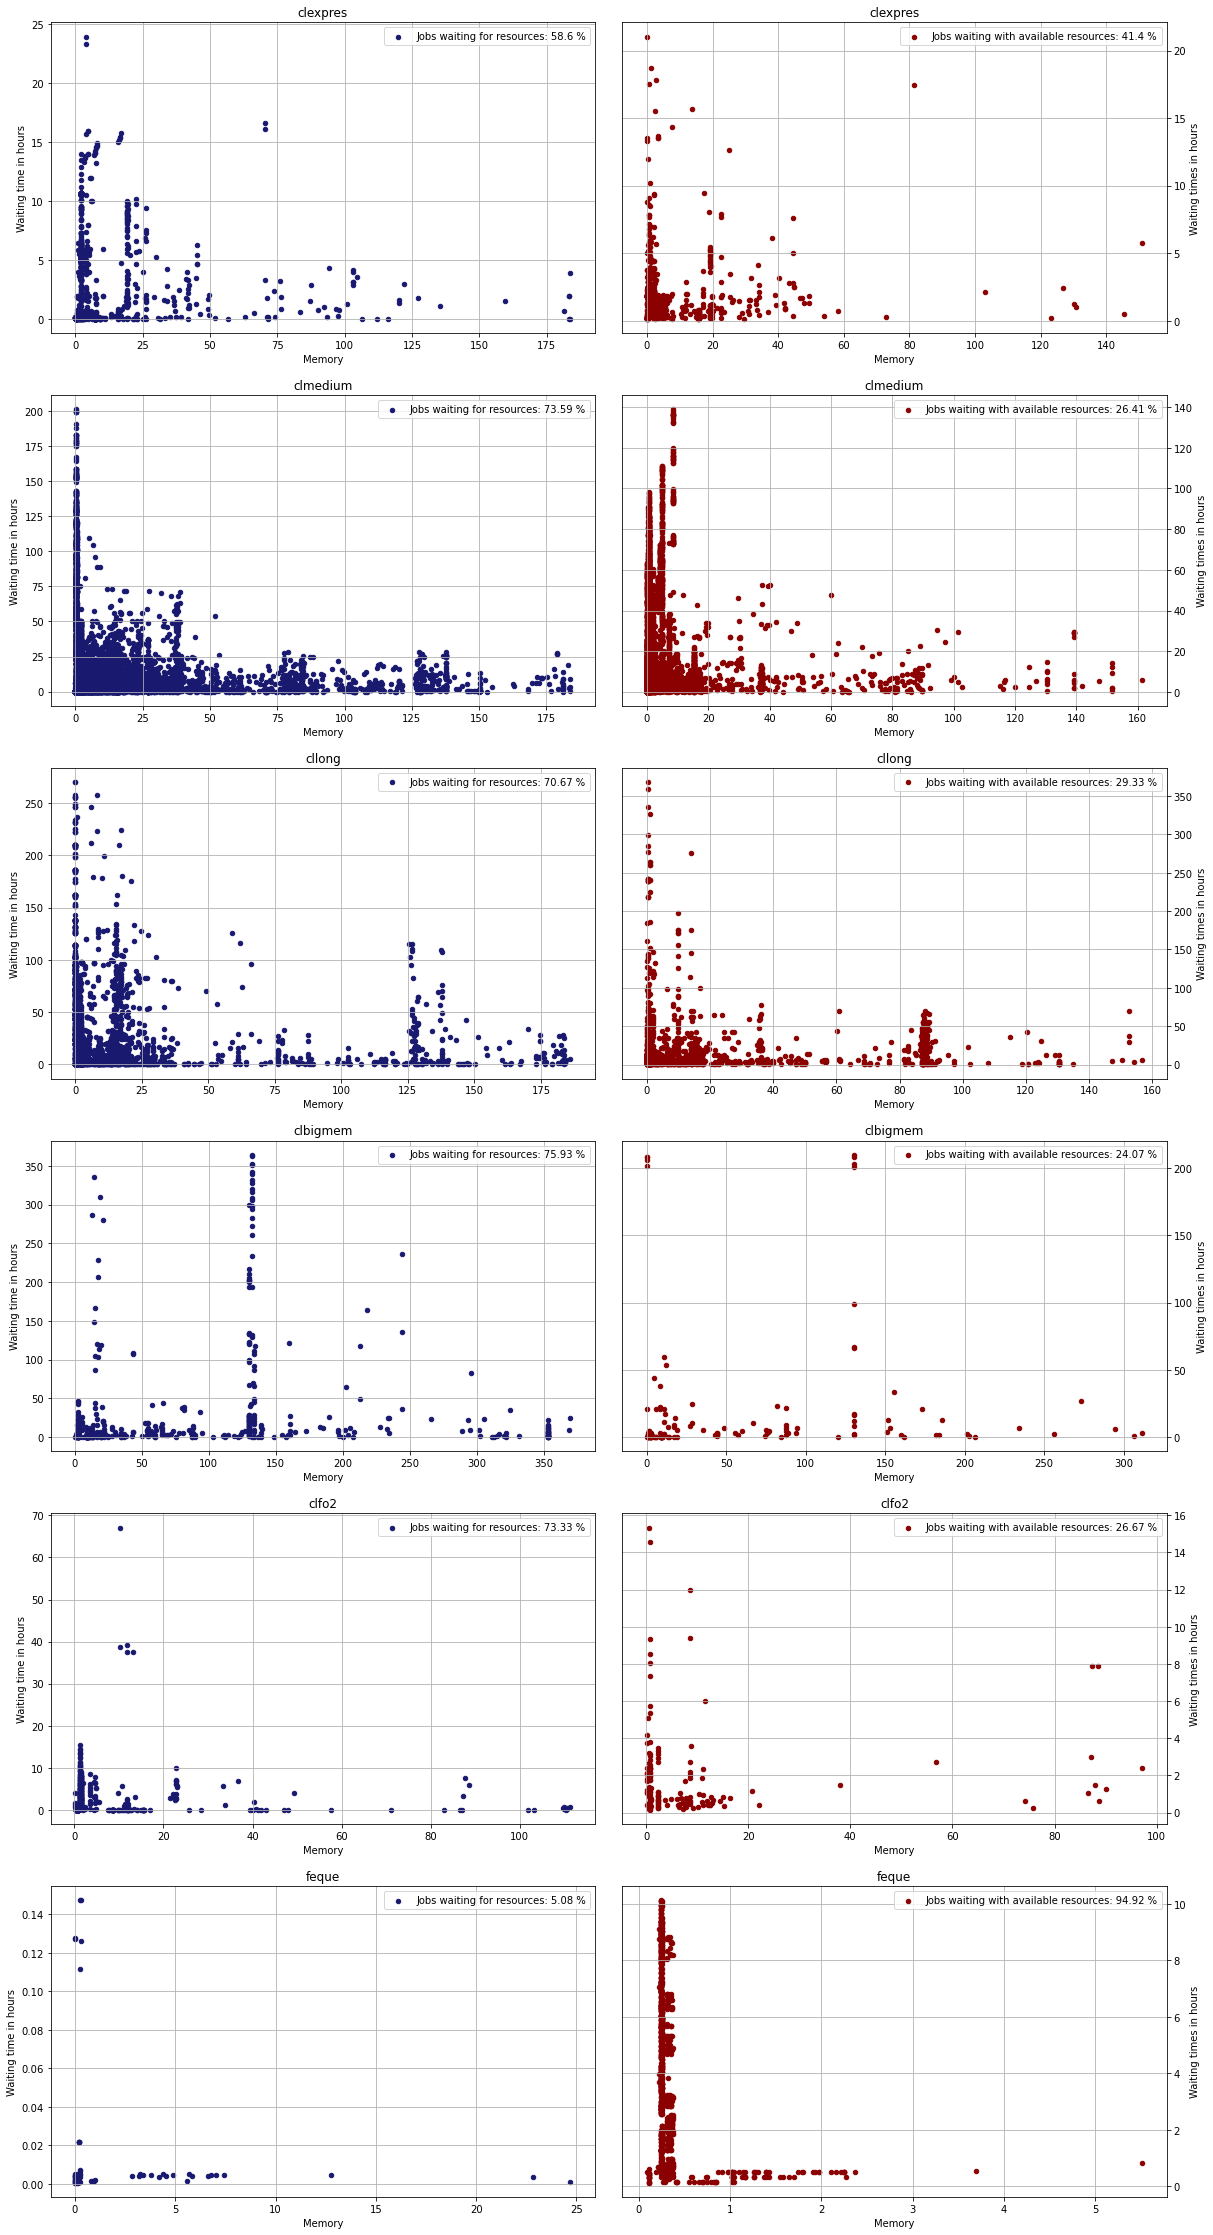

In [7]:
fig, axs = plt.subplots(len(batch_classes),2,figsize=(20,40))
fig.subplots_adjust(wspace=0.05)
for i in range(0,len(batch_classes)):
    batch_class  = batch_classes[i]
    job_bclass   = job_chars[job_chars['Batch_class'].str.contains(batch_class)]
    mask         = (job_bclass['Mem_utilization'] > 1.) & (job_bclass['CPU_utilization'] > 1.)
    job_bclass_b = job_bclass[~mask] 
    job_bclass_r = job_bclass[mask] 
    ratio_r      = str(round(10000*len(job_bclass_r.index)/len(job_bclass.index))/100)
    ratio_b      = str(round(10000*len(job_bclass_b.index)/len(job_bclass.index))/100)
    job_bclass_b.plot.scatter('Memory','Waited',c='midnightblue',ax=axs[i,0],label=('Jobs waiting for resources: '+ ratio_b + ' %'))
    job_bclass_r.plot.scatter('Memory','Waited',c='darkred',ax=axs[i,1],label=('Jobs waiting with available resources: '+ ratio_r + ' %'))
    axs[i,0].set_title(batch_class)
    mn, mx = axs[i,0].get_ylim()
    axs[i,0].set_ylabel('Waiting time in hours')
    axs[i,0].grid()
    axs[i,1].yaxis.tick_right()
    axs[i,1].yaxis.set_label_position("right")
    axs[i,1].set_ylabel('Waiting times in hours')
    axs[i,1].set_title(batch_class)
    axs[i,1].grid()

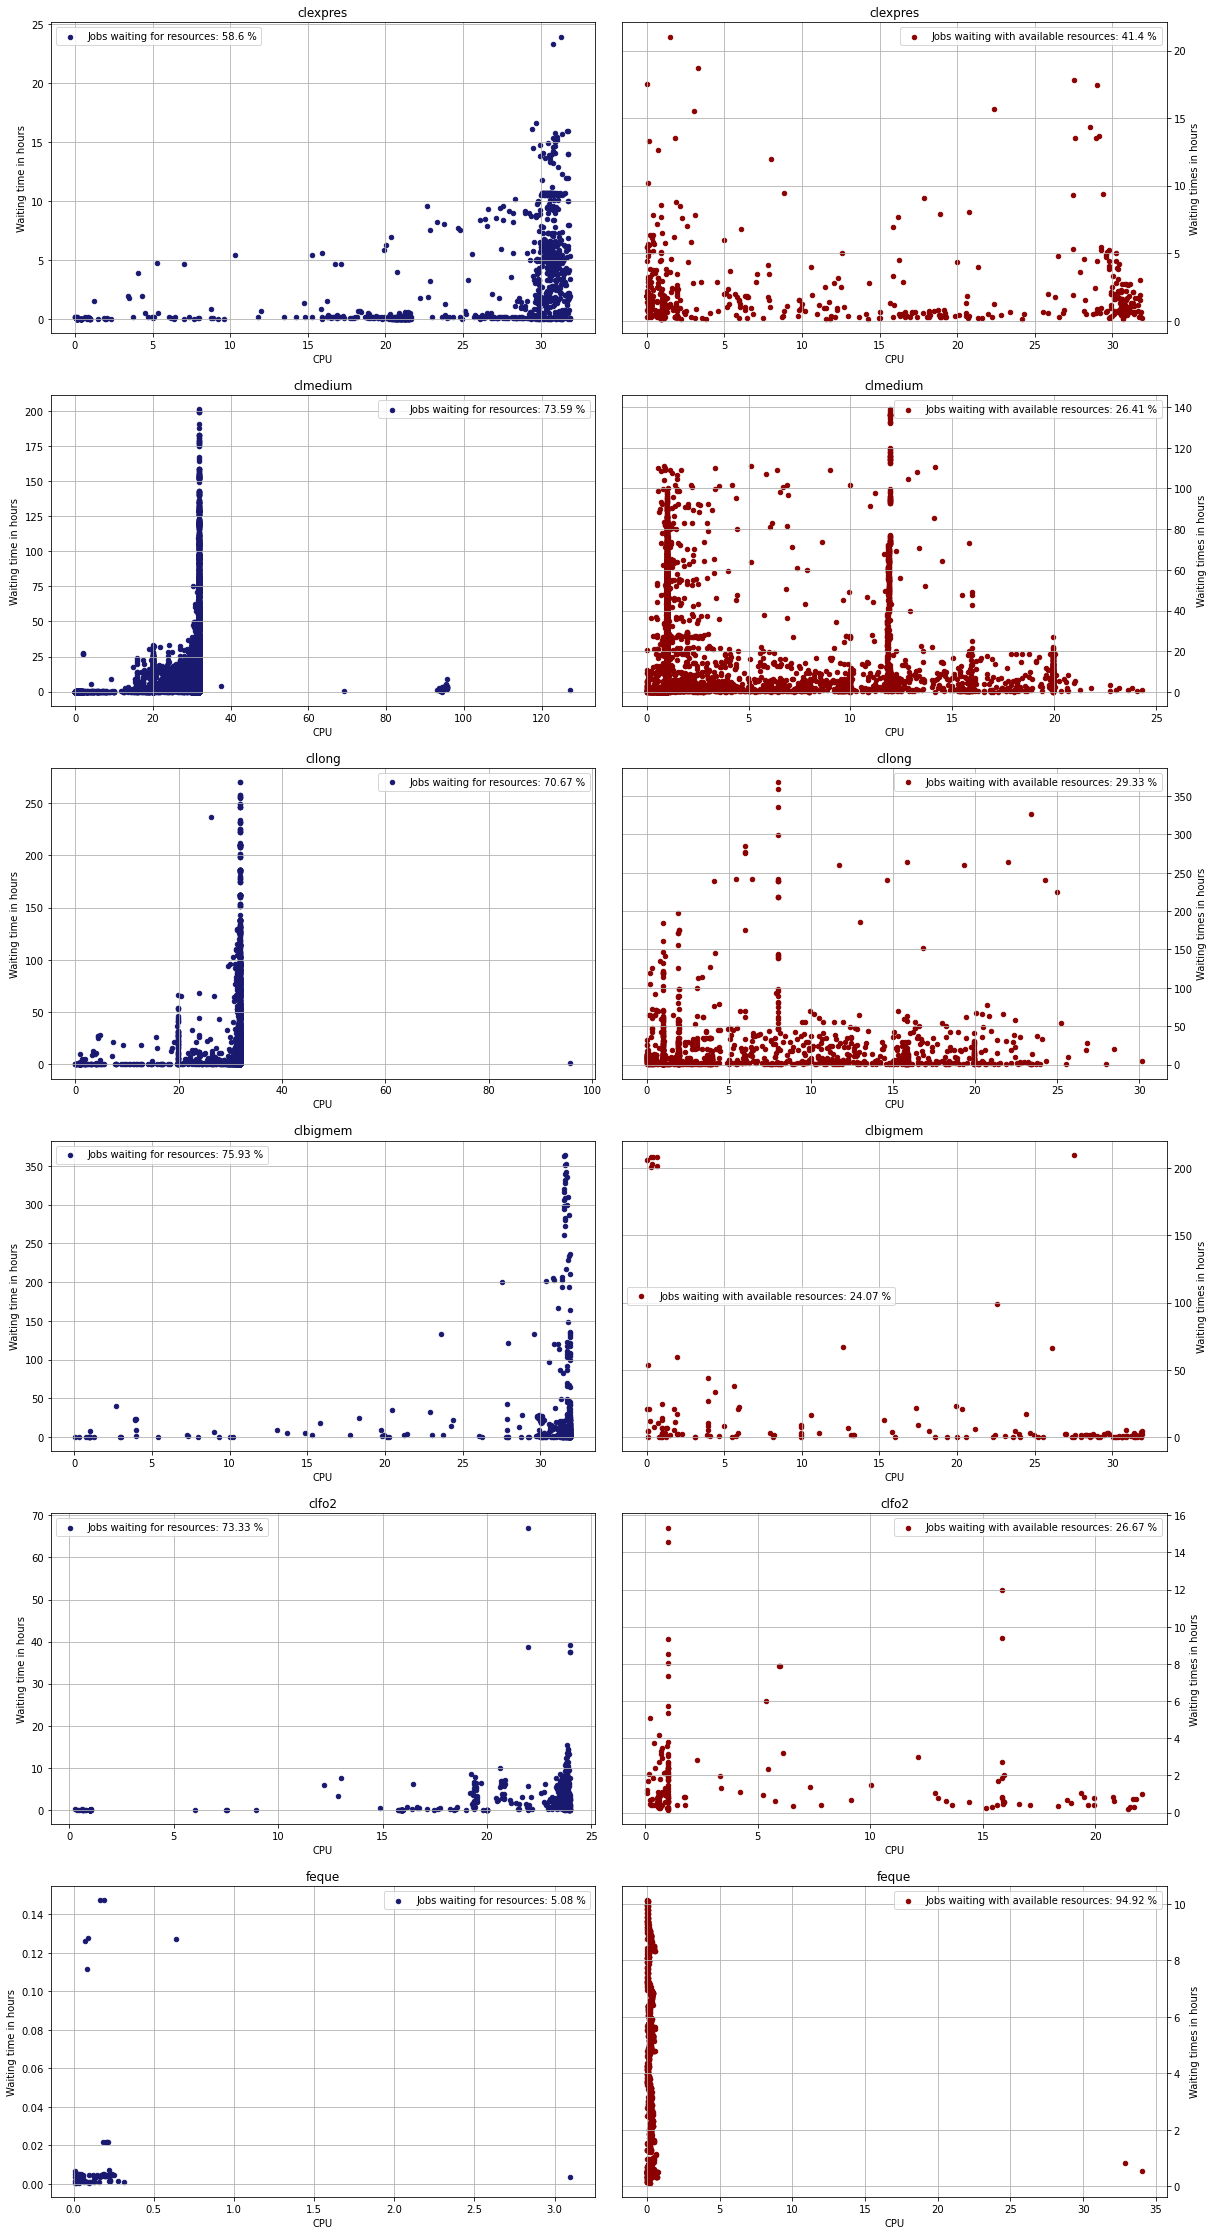

In [8]:
fig, axs = plt.subplots(len(batch_classes),2,figsize=(20,40))
fig.subplots_adjust(wspace=0.05)
for i in range(0,len(batch_classes)):
    batch_class  = batch_classes[i]
    job_bclass   = job_chars[job_chars['Batch_class'].str.contains(batch_class)]
    mask         = (job_bclass['Mem_utilization'] > 1.) & (job_bclass['CPU_utilization'] > 1.)
    job_bclass_b = job_bclass[~mask] 
    job_bclass_r = job_bclass[mask] 
    ratio_r      = str(round(10000*len(job_bclass_r.index)/len(job_bclass.index))/100)
    ratio_b      = str(round(10000*len(job_bclass_b.index)/len(job_bclass.index))/100)
    job_bclass_b.plot.scatter('CPU','Waited',c='midnightblue',ax=axs[i,0],label=('Jobs waiting for resources: '+ ratio_b + ' %'))
    job_bclass_r.plot.scatter('CPU','Waited',c='darkred',ax=axs[i,1],label=('Jobs waiting with available resources: '+ ratio_r + ' %'))
    axs[i,0].set_title(batch_class)
    mn, mx = axs[i,0].get_ylim()
    axs[i,0].set_ylabel('Waiting time in hours')
    axs[i,0].grid()
    axs[i,1].yaxis.tick_right()
    axs[i,1].yaxis.set_label_position("right")
    axs[i,1].set_ylabel('Waiting times in hours')
    axs[i,1].set_title(batch_class)
    axs[i,1].grid()

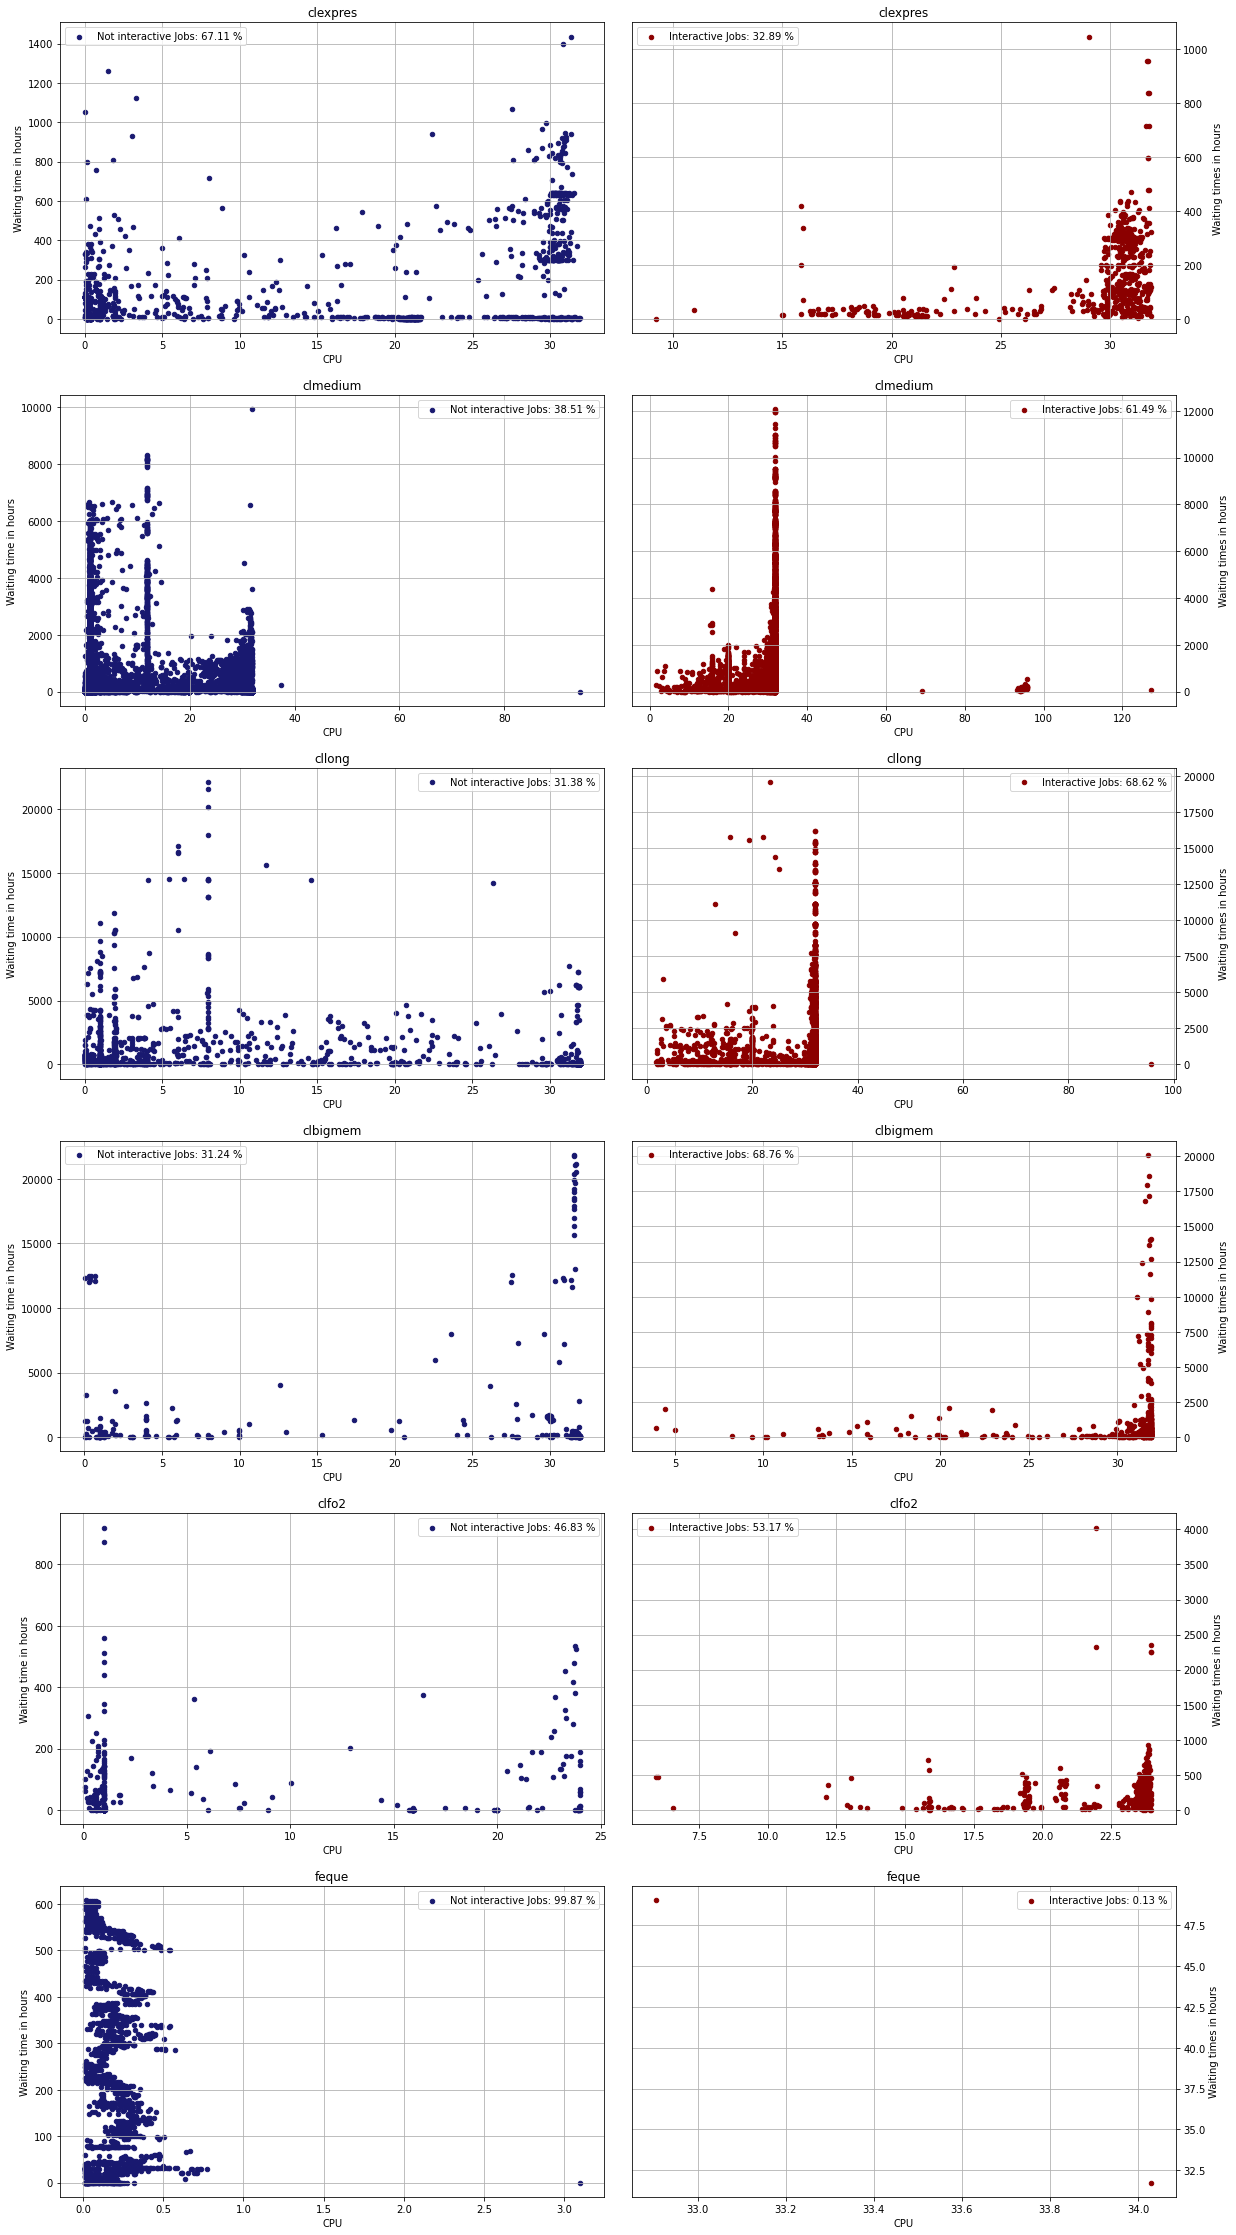

In [33]:
fig, axs = plt.subplots(len(batch_classes),2,figsize=(20,40))
fig.subplots_adjust(wspace=0.05)
for i in range(0,len(batch_classes)):
    batch_class  = batch_classes[i]
    job_bclass   = job_chars[job_chars['Batch_class'].str.contains(batch_class)]
    mask         = (job_bclass['interactivity score'] > 13.) 
    job_bclass_inter  = job_bclass[mask] 
    job_bclass_ninter = job_bclass[~mask] 
    ratio_inter      = str(round(10000*len(job_bclass_inter.index)/len(job_bclass.index))/100)
    ratio_ninter     = str(round(10000*len(job_bclass_ninter.index)/len(job_bclass.index))/100)
    job_bclass_ninter.plot.scatter('CPU','Waited',c='midnightblue',ax=axs[i,0],label=('Not interactive Jobs: '+ ratio_ninter + ' %'))
    job_bclass_inter.plot.scatter('CPU','Waited',c='darkred',ax=axs[i,1],label=('Interactive Jobs: '+ ratio_inter + ' %'))
    axs[i,0].set_title(batch_class)
    mn, mx = axs[i,0].get_ylim()
    axs[i,0].set_ylabel('Waiting time in hours')
    axs[i,0].grid()
    axs[i,1].yaxis.tick_right()
    axs[i,1].yaxis.set_label_position("right")
    axs[i,1].set_ylabel('Waiting times in hours')
    axs[i,1].set_title(batch_class)
    axs[i,1].grid()

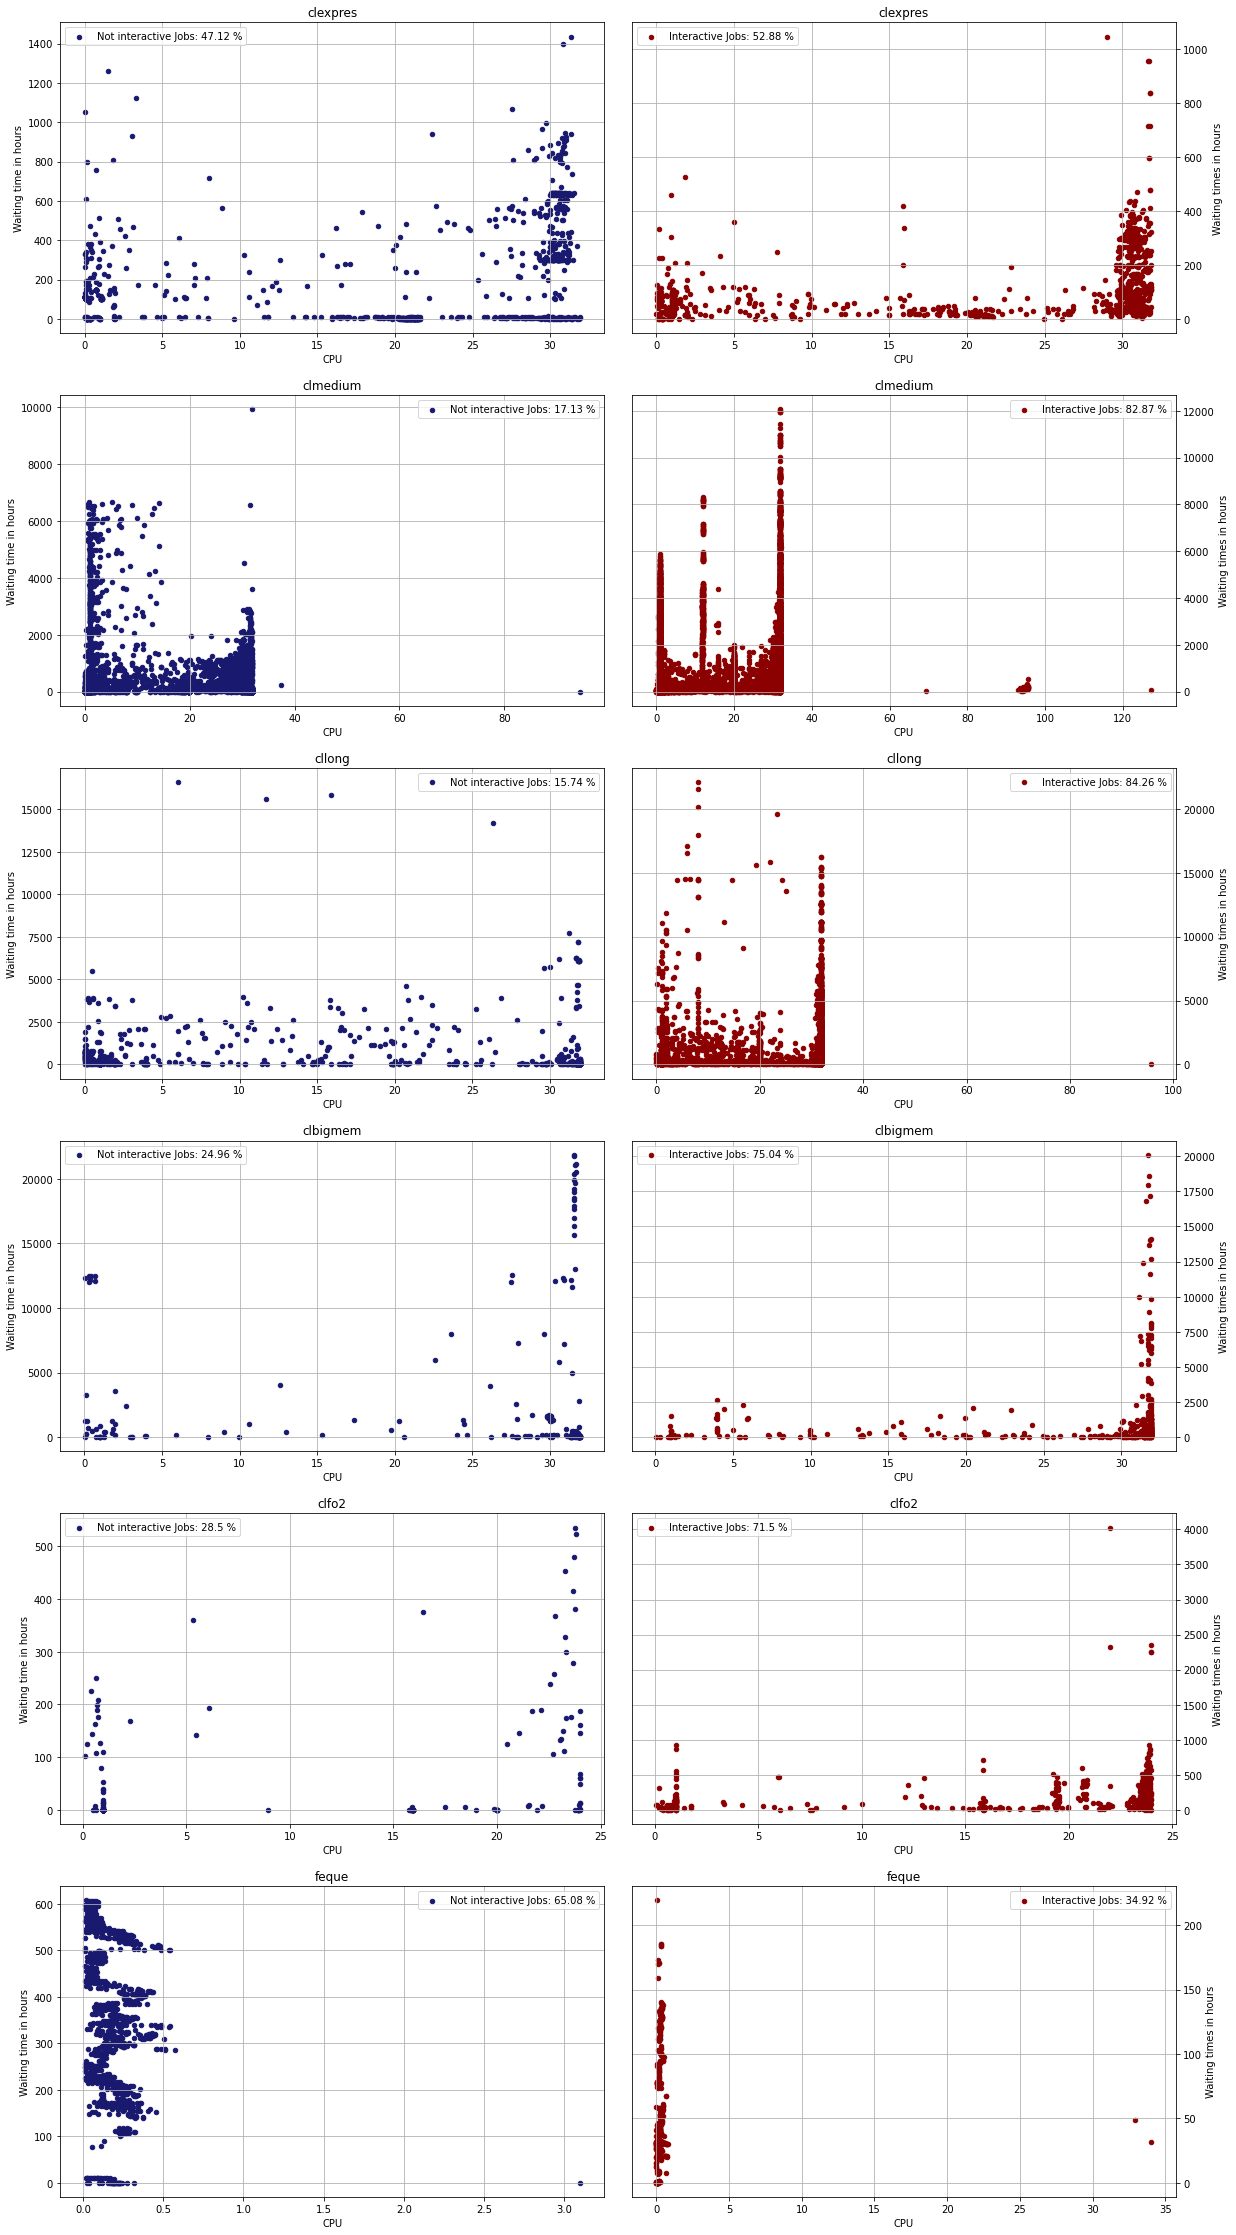

In [34]:
fig, axs = plt.subplots(len(batch_classes),2,figsize=(20,40))
fig.subplots_adjust(wspace=0.05)
for i in range(0,len(batch_classes)):
    batch_class  = batch_classes[i]
    job_bclass   = job_chars[job_chars['Batch_class'].str.contains(batch_class)]
    mask         = (job_bclass['normalized max'] > 0.5) 
    job_bclass_inter  = job_bclass[mask] 
    job_bclass_ninter = job_bclass[~mask] 
    ratio_inter      = str(round(10000*len(job_bclass_inter.index)/len(job_bclass.index))/100)
    ratio_ninter     = str(round(10000*len(job_bclass_ninter.index)/len(job_bclass.index))/100)
    job_bclass_ninter.plot.scatter('CPU','Waited',c='midnightblue',ax=axs[i,0],label=('Not interactive Jobs: '+ ratio_ninter + ' %'))
    job_bclass_inter.plot.scatter('CPU','Waited',c='darkred',ax=axs[i,1],label=('Interactive Jobs: '+ ratio_inter + ' %'))
    axs[i,0].set_title(batch_class)
    mn, mx = axs[i,0].get_ylim()
    axs[i,0].set_ylabel('Waiting time in hours')
    axs[i,0].grid()
    axs[i,1].yaxis.tick_right()
    axs[i,1].yaxis.set_label_position("right")
    axs[i,1].set_ylabel('Waiting times in hours')
    axs[i,1].set_title(batch_class)
    axs[i,1].grid()

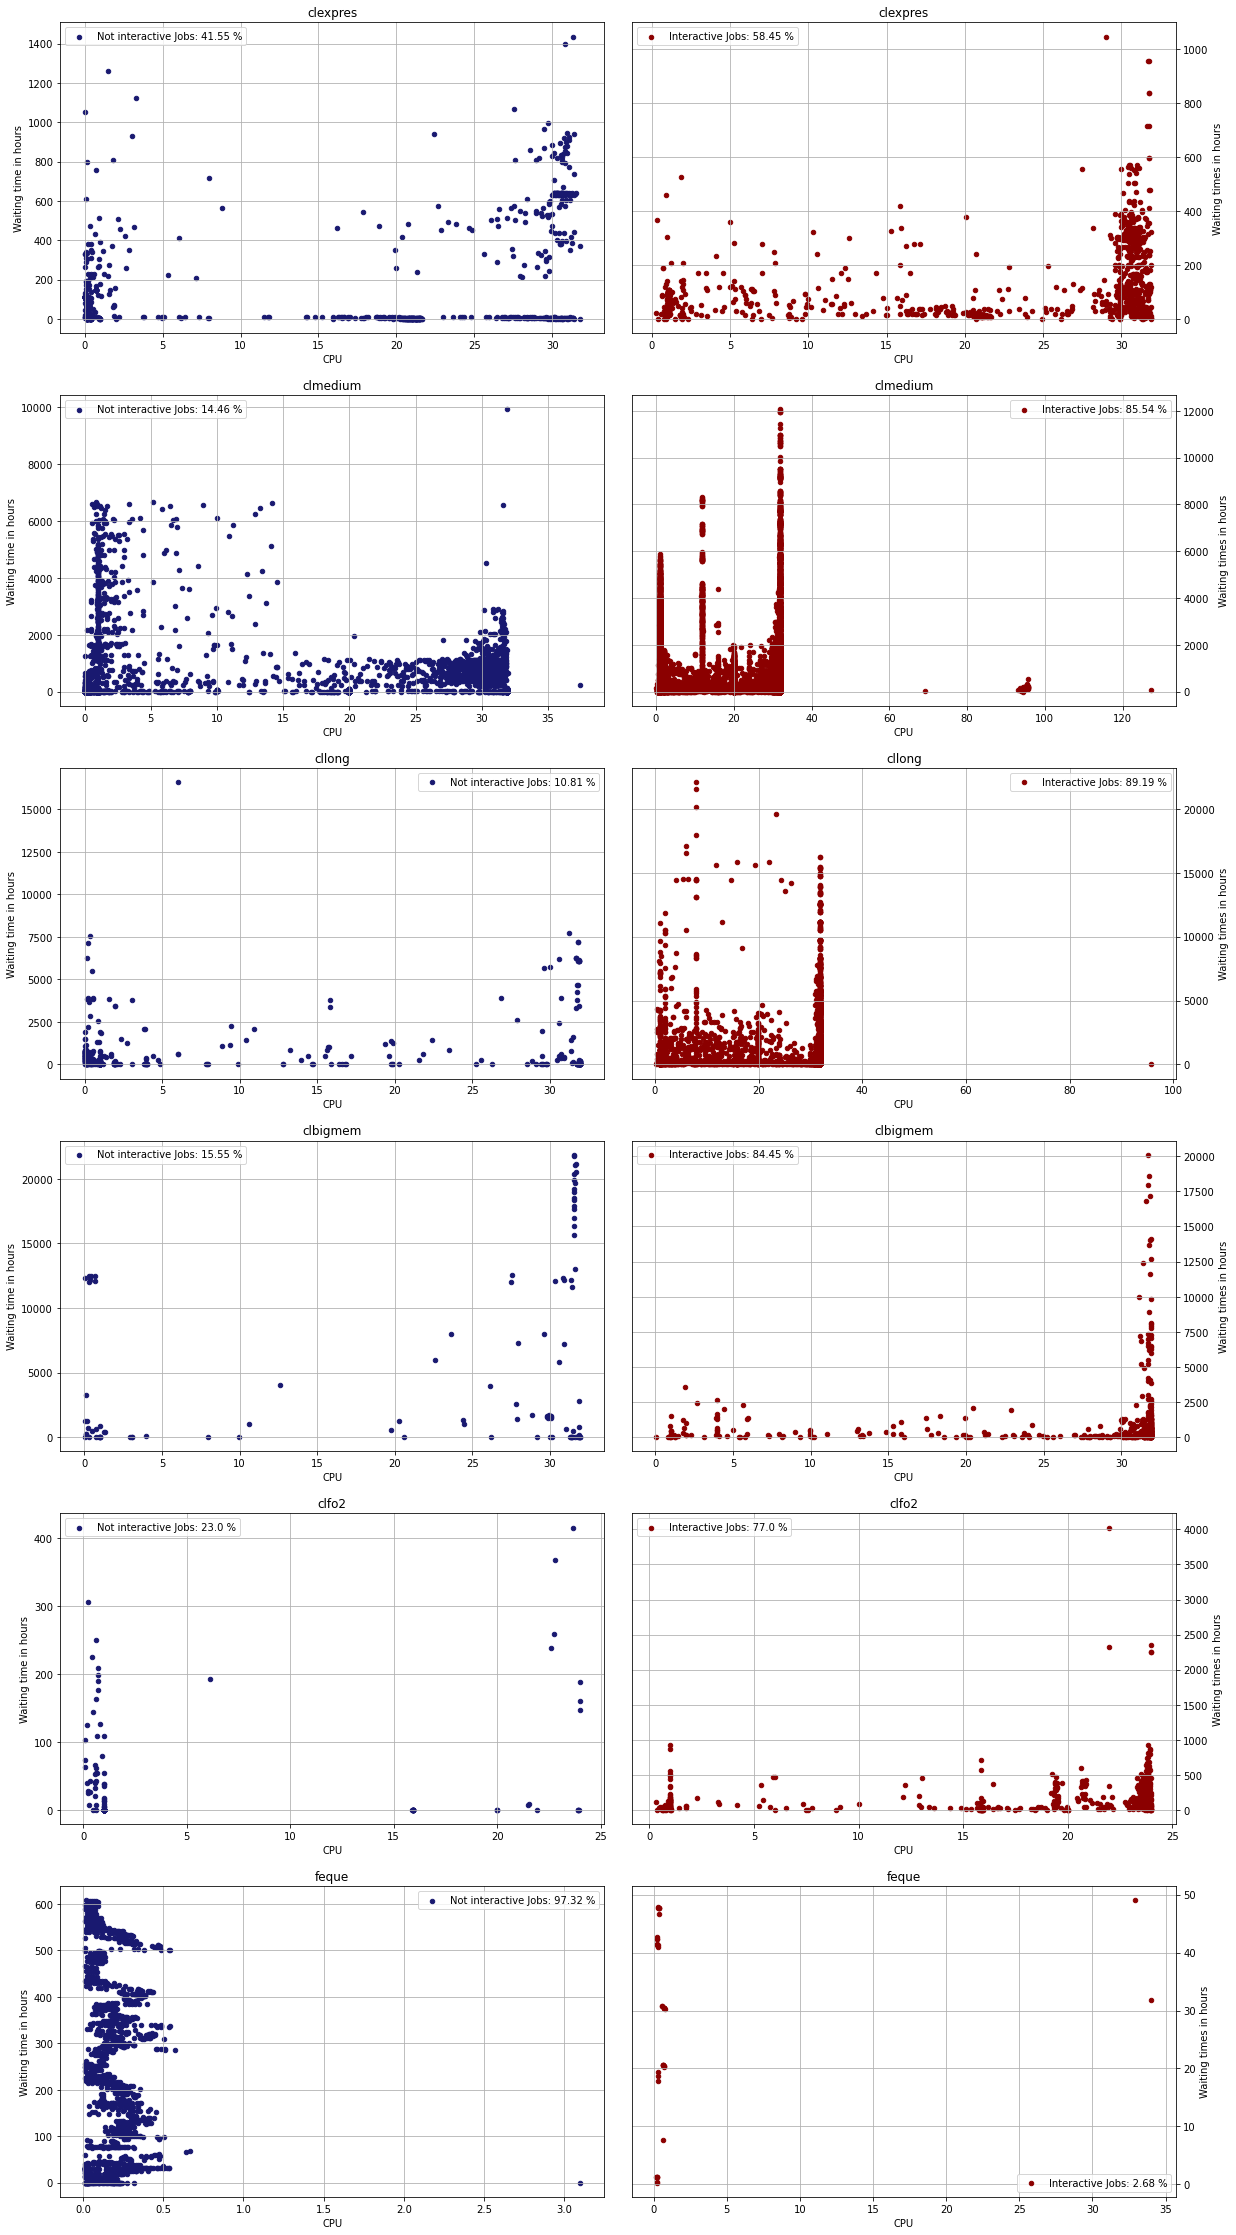

In [39]:
fig, axs = plt.subplots(len(batch_classes),2,figsize=(20,40))
fig.subplots_adjust(wspace=0.05)
for i in range(0,len(batch_classes)):
    batch_class  = batch_classes[i]
    job_bclass   = job_chars[job_chars['Batch_class'].str.contains(batch_class)]
    mask         = (job_bclass['interactivity score'] > 0.5) 
    job_bclass_inter  = job_bclass[mask] 
    job_bclass_ninter = job_bclass[~mask] 
    ratio_inter      = str(round(10000*len(job_bclass_inter.index)/len(job_bclass.index))/100)
    ratio_ninter     = str(round(10000*len(job_bclass_ninter.index)/len(job_bclass.index))/100)
    job_bclass_ninter.plot.scatter('CPU','Waited',c='midnightblue',ax=axs[i,0],label=('Not interactive Jobs: '+ ratio_ninter + ' %'))
    job_bclass_inter.plot.scatter('CPU','Waited',c='darkred',ax=axs[i,1],label=('Interactive Jobs: '+ ratio_inter + ' %'))
    axs[i,0].set_title(batch_class)
    mn, mx = axs[i,0].get_ylim()
    axs[i,0].set_ylabel('Waiting time in hours')
    axs[i,0].grid()
    axs[i,1].yaxis.tick_right()
    axs[i,1].yaxis.set_label_position("right")
    axs[i,1].set_ylabel('Waiting times in hours')
    axs[i,1].set_title(batch_class)
    axs[i,1].grid()